In [156]:
from utils import *
import tensorflow as tf
from keras.optimizers import Adam
from keras import utils

In [157]:
df_dict , max_rows, num_features = read_conv(train=True)
features, depression_labels, gender_labels = prep_conv_data(df_dict, max_rows, num_features)

Removing null values present in spk_402.csv


In [158]:
# define and train CNN Model
utils.set_random_seed(3)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (16, 16), padding="same", use_bias = True, activation='relu',
                           input_shape=(378, 88, 1),
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (8, 8),use_bias = True, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 378, 88, 8)        2056      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 189, 44, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 182, 37, 16)       8208      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 91, 18, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 26208)             0         
                                                                 
 dense_30 (Dense)            (None, 128)             

In [159]:
unique_classes, class_counts = np.unique(gender_labels, return_counts=True)
total_samples = gender_labels.shape[0]
class_weights = {}

for class_label, class_count in zip(unique_classes, class_counts):
    class_weight = total_samples / (2.0 * class_count)
    class_weights[class_label] = class_weight

In [160]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                              patience=3)
history = model.fit(features, gender_labels, epochs=25, batch_size=8, 
                    #callbacks=[callback],
                    validation_split=0.15,
                    class_weight=class_weights)

Epoch 1/25
10/10 [==============================] - 4s 321ms/step - loss: 102.7472 - accuracy: 0.5616 - val_loss: 80.8861 - val_accuracy: 0.2857
Epoch 2/25
10/10 [==============================] - 3s 312ms/step - loss: 97.6077 - accuracy: 0.4795 - val_loss: 80.6218 - val_accuracy: 0.1429
Epoch 3/25
10/10 [==============================] - 3s 313ms/step - loss: 49.7099 - accuracy: 0.6164 - val_loss: 68.6232 - val_accuracy: 0.1429
Epoch 4/25
10/10 [==============================] - 3s 307ms/step - loss: 33.5472 - accuracy: 0.6849 - val_loss: 42.7334 - val_accuracy: 0.5714
Epoch 5/25
10/10 [==============================] - 3s 305ms/step - loss: 27.3546 - accuracy: 0.6712 - val_loss: 50.8645 - val_accuracy: 0.2857
Epoch 6/25
10/10 [==============================] - 3s 307ms/step - loss: 14.5911 - accuracy: 0.7123 - val_loss: 13.5581 - val_accuracy: 0.2857
Epoch 7/25
10/10 [==============================] - 3s 307ms/step - loss: 10.9187 - accuracy: 0.6849 - val_loss: 19.6094 - val_accuracy

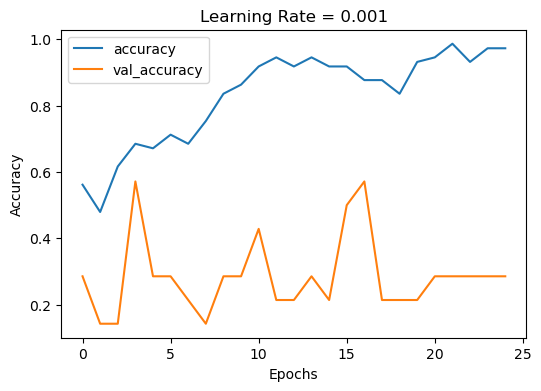

In [161]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [162]:
test_df_dict , _, _ = read_conv(train=False)
test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df_dict, max_rows, num_features)

In [163]:
test_loss, test_acc = model.evaluate(test_features,  test_gender_labels)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

1/1 [==============================] - 0s 73ms/step - loss: 1.0681 - accuracy: 0.8000
Test loss:  1.0681278705596924
Test accuracy:  0.800000011920929


In [164]:
PATH_TEST = "../processed_data/cleaned_data/clean_test_data.csv"
test_df = pd.read_csv(PATH_TEST)
y_test = test_df[["Participant_ID", "Depression", "Gender"]]
y_test = y_test.groupby("Participant_ID").agg({"Depression":"max", "Gender":"max"}).reset_index()
y_test.head()

,Participant_ID,Depression,Gender
0,305,0,1
1,312,0,1
2,315,0,1
3,320,1,0
4,321,1,0


In [165]:
y_test["Gender_predicted"] = model.predict(test_features)
y_test['Gender_predicted'] = np.where(y_test['Gender_predicted']>=0.5, 1, 0)

1/1 [==============================] - 0s 91ms/step


Accuracy: 0.7
Balanced Accuracy: 0.6666666666666667


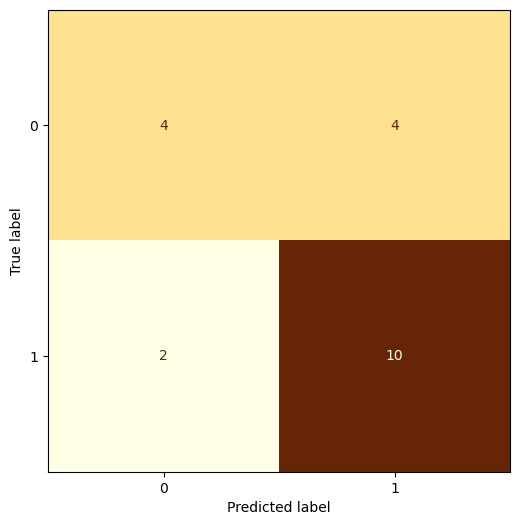

In [166]:
# Compute metrics
accuracy = accuracy_score(y_test['Gender'], y_test['Gender_predicted'])
bal_accuracy = balanced_accuracy_score(y_test['Gender'], y_test['Gender_predicted'])

print(f"Accuracy: {accuracy}")
print(f"Balanced Accuracy: {bal_accuracy}")
conf_matrix = confusion_matrix(y_test['Gender'], y_test['Gender_predicted'])
#Visualizing the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='YlOrBr', colorbar=False)
plt.show()